# Inference of Gene Correlations using Pearson


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-15


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')

import lib.minibulk_funcs as mb
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.figs_funcs as figfunc
import lib.funcs_sanity as funcs_sanity



%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Raw data

In [5]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",")
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

df_raw = df_raw.reindex(genes_order)
    
df_raw.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1,1,0,1,3,3,0,2,2,0,...,0,2,1,0,0,0,0,0,0,0
Klf2,1,0,1,2,0,2,6,6,1,2,...,0,3,1,0,0,0,3,0,0,2
Esrrb,0,1,0,2,1,0,0,2,0,0,...,0,1,0,0,0,0,1,1,0,0


In [6]:
# PST
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

pst_df = pst_df.sort_values(by=['pst'])

# reordering dataframe 
column_names = pst_df["barcodes"]
df_raw_pst = df_raw.reindex(columns = column_names)





# Norm Data

In [7]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [8]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## MB

In [9]:
mb_wind = 150


In [10]:
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=mb_wind)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)
df_raw_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,1.793333,1.640000,1.533333,1.613333,1.426667,1.593333,1.533333,1.480000,1.826667,1.653333,...,0.406667,0.366667,0.326667,0.306667,0.260000,0.280000,0.353333,0.360000,0.286667,0.353333
Klf2,2.393333,2.153333,2.046667,2.173333,2.160000,1.940000,2.173333,2.153333,2.086667,2.260000,...,0.986667,0.886667,1.020000,0.766667,0.840000,0.773333,1.020000,0.873333,0.873333,0.906667
Esrrb,0.533333,0.573333,0.440000,0.513333,0.426667,0.380000,0.460000,0.560000,0.453333,0.513333,...,0.246667,0.293333,0.240000,0.220000,0.226667,0.206667,0.226667,0.173333,0.240000,0.233333


In [11]:
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=mb_wind)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)
df_lN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.873333,0.793333,0.753333,0.86,0.760000,0.840000,0.733333,0.780000,0.880000,0.786667,...,0.200000,0.160000,0.133333,0.173333,0.126667,0.146667,0.200000,0.186667,0.113333,0.173333
Klf2,1.060000,0.973333,0.966667,1.04,1.033333,0.906667,0.993333,1.120000,0.966667,1.033333,...,0.466667,0.380000,0.506667,0.413333,0.393333,0.413333,0.513333,0.480000,0.400000,0.473333
Esrrb,0.226667,0.280000,0.220000,0.28,0.240000,0.226667,0.226667,0.293333,0.206667,0.273333,...,0.126667,0.153333,0.106667,0.120000,0.133333,0.093333,0.133333,0.120000,0.093333,0.120000


In [12]:
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=mb_wind)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)
df_pN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.826667,0.760000,0.720000,0.813333,0.713333,0.793333,0.680000,0.746667,0.846667,0.773333,...,0.200000,0.146667,0.140000,0.160000,0.100000,0.146667,0.186667,0.173333,0.126667,0.180000
Klf2,1.066667,0.953333,0.980000,1.020000,1.060000,0.920000,0.980000,1.100000,0.946667,1.020000,...,0.453333,0.380000,0.493333,0.393333,0.366667,0.393333,0.486667,0.433333,0.406667,0.453333
Esrrb,0.220000,0.293333,0.206667,0.253333,0.233333,0.213333,0.213333,0.293333,0.213333,0.266667,...,0.120000,0.133333,0.100000,0.106667,0.120000,0.080000,0.126667,0.100000,0.093333,0.100000


## PST + MB

In [13]:
# Window size for Mini-Bulk

# Threshold for half max
thr = 0.5 

In [14]:
# Mini-bulk
df_raw_mb_pst = df_raw_pst.rolling(window = mb_wind, axis=1).mean().dropna(axis=1)
df_raw_mb_pst = pd.DataFrame(df_raw_mb_pst, index=df_raw_pst.index)
df_raw_mb_pst.head(3)

barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
Klf4,1.340000,1.340000,1.353333,1.353333,1.366667,1.406667,1.426667,1.426667,1.426667,1.413333,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.213333,0.213333
Klf2,1.233333,1.240000,1.226667,1.226667,1.233333,1.266667,1.260000,1.260000,1.280000,1.286667,...,0.633333,0.626667,0.606667,0.606667,0.580000,0.580000,0.573333,0.573333,0.560000,0.553333
Esrrb,0.240000,0.246667,0.253333,0.246667,0.233333,0.246667,0.260000,0.260000,0.260000,0.260000,...,0.206667,0.206667,0.206667,0.206667,0.206667,0.213333,0.213333,0.220000,0.226667,0.226667


In [15]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Known Experimentally

## Neighbours interactions

In [16]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [17]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

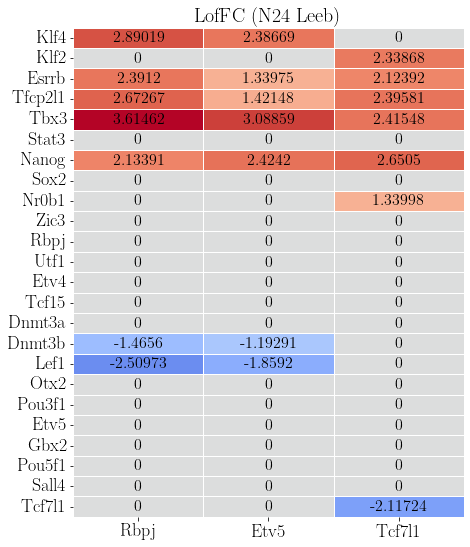

In [18]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Bulk Data

In [19]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")

file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name).set_index(imp_genes).reindex(genes_order)

df_bulk = df_bulk_all.iloc[:,2: ]
df_bulk.head(4)

# df2iL = df.iloc[:,2:18]
# df2i = df.iloc[:,18:]
# ntime=np.array([0, 0, 24, 24, 36, 36, 48, 48, 60, 60, 72, 72, 84, 84, 96, 96])



,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726
Tfcp2l1,797.584148,796.803401,135.395133,111.271328,69.511885,70.166836,22.339207,18.713434,6.097000,6.453556,...,7.912597,5.470391,6.359776,6.089380,7.104881,7.725532,4.722182,9.22665,12.284710,8.238689


# Noise threshold

In [20]:
df_list = [df_bulk, df_raw, df_lN, df_pN, df_raw_mb, df_lN_mb, df_pN_mb, df_lN_mb_pst, df_pN_mb_pst]
df_name = ["Bulk data", "Raw data", "LogNorm data", "PsiNorm data", "Raw + MB, size "+str(mb_wind), "LogNorm + MB, size "+str(mb_wind), "PsiNorm + MB, size "+str(mb_wind), "LogNorm + PST + MB", "PsiNorm + PST + MB"]


Analysing:  Bulk data
regression score 0.7386722595048854
The noise-threshold is  0.535


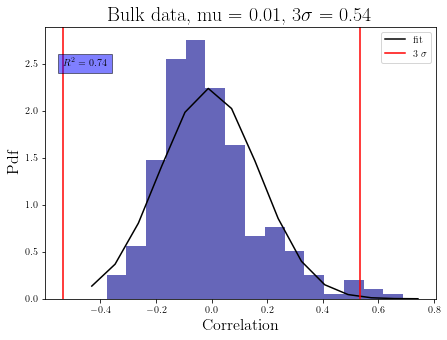

Analysing:  Raw data
regression score 0.9101766611838681
The noise-threshold is  0.031


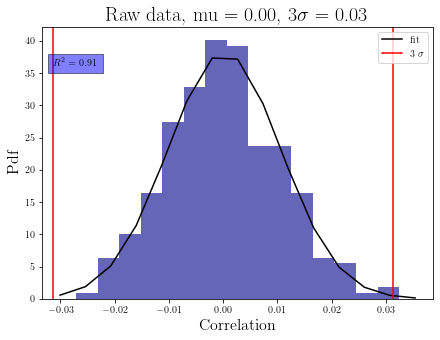

Analysing:  LogNorm data
regression score 0.8908626228991856
The noise-threshold is  0.031


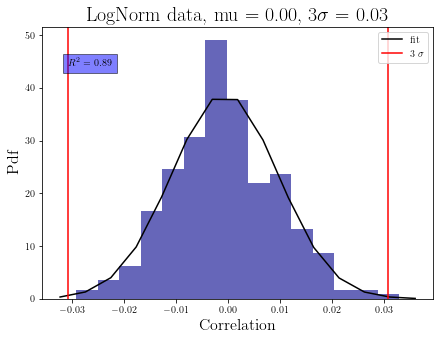

Analysing:  PsiNorm data
regression score 0.8916734583385727
The noise-threshold is  0.031


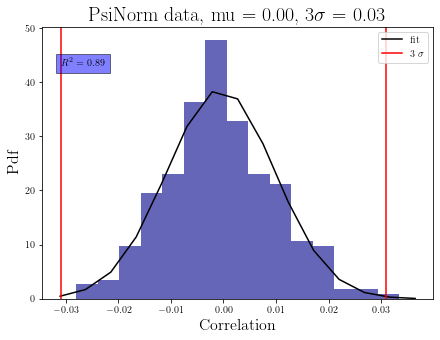

Analysing:  Raw + MB, size 150
regression score 0.8301097411038209
The noise-threshold is  0.029


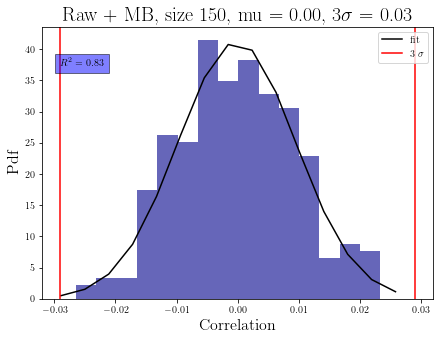

Analysing:  LogNorm + MB, size 150
regression score 0.6955266260353604
The noise-threshold is  0.029


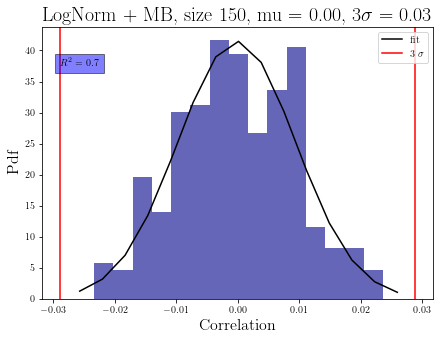

Analysing:  PsiNorm + MB, size 150
regression score 0.8128313941238021
The noise-threshold is  0.029


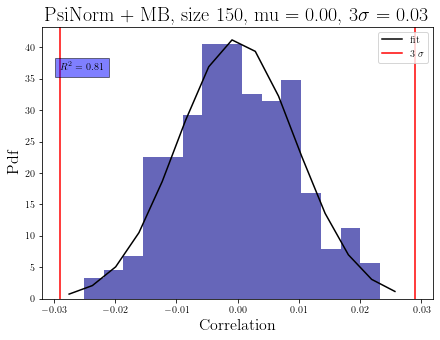

Analysing:  LogNorm + PST + MB
regression score 0.9124885835322208
The noise-threshold is  0.031


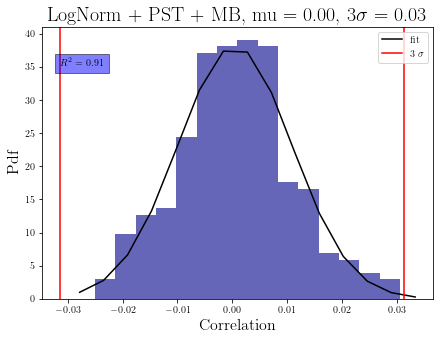

Analysing:  PsiNorm + PST + MB
regression score 0.9275006882450851
The noise-threshold is  0.034


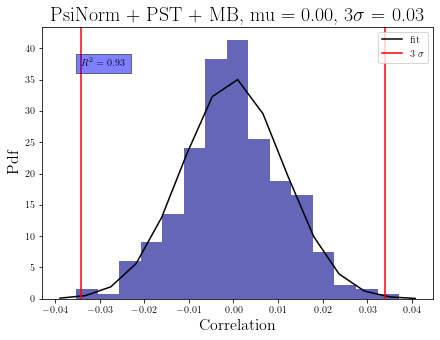

In [21]:
# Evaluate the number of known interaction for all the cm matrices in a for
for i in range(len(df_list)):
    print("Analysing: ", df_name[i])
    TP_frac_rnd, info_int_rnd, corr_matrices = funcs_sanity.shuffle_dataframe(df_list[i], genes_order, TPtrial_list, inferred_int_thr = 0, N_test=1000)
    # funcs_sanity.plot_TP_fraction(TP_frac_rnd, df_name[i])
    funcs_sanity.fit_normal_distribution(corr_matrices, noise_thr=3, text=df_name[i], Nbins=15)

# Correlation Matrices

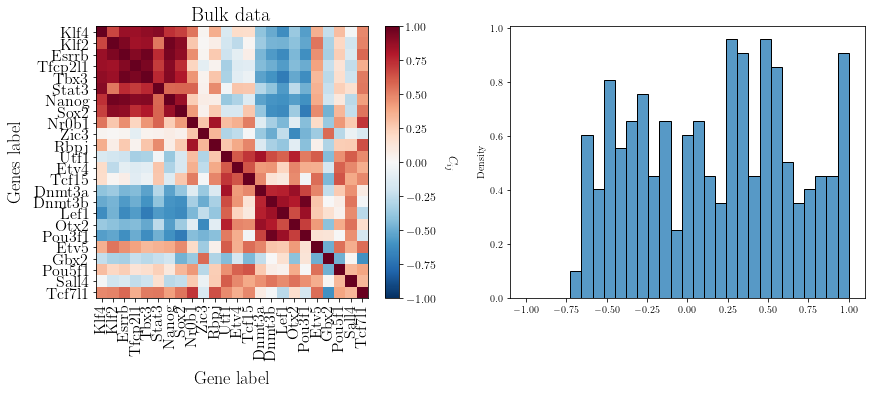

fraction of correctly inffered interactions: 0.56
Wrong Ints:  Stat3 - Gbx2 val = -0.23
Wrong Ints:  Tcf7l1 - Esrrb val = 0.57
Wrong Ints:  Tcf7l1 - Klf2 val = 0.50
Wrong Ints:  Tcf7l1 - Nanog val = 0.41
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.72
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.36
Wrong Ints:  Rbpj - Nanog val = 0.07
Wrong Ints:  Rbpj - Tbx3 val = 0.28


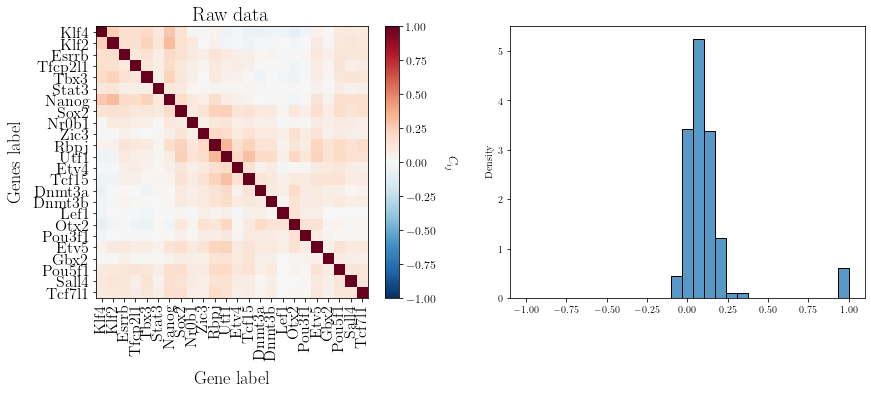

fraction of correctly inffered interactions: 0.39
Wrong Ints:  Stat3 - Dnmt3b val = 0.00
Wrong Ints:  Nanog - Otx2 val = -0.02
Wrong Ints:  Nanog - Pou3f1 val = 0.01
Wrong Ints:  Stat3 - Gbx2 val = 0.01
Wrong Ints:  Tcf7l1 - Esrrb val = 0.12
Wrong Ints:  Tcf7l1 - Klf2 val = 0.11
Wrong Ints:  Tcf7l1 - Nanog val = 0.16
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.07
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.08
Wrong Ints:  Rbpj - Nanog val = 0.18
Wrong Ints:  Rbpj - Tbx3 val = 0.10


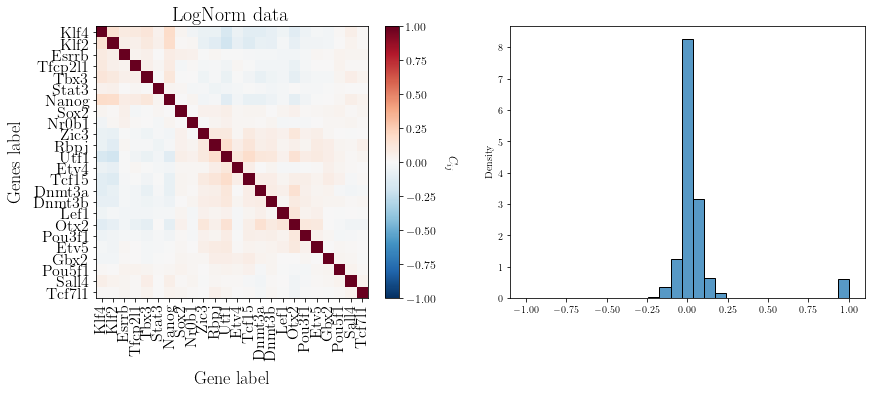

fraction of correctly inffered interactions: 0.44
Wrong Ints:  Stat3 - Dnmt3b val = -0.02
Wrong Ints:  Stat3 - Gbx2 val = -0.01
Wrong Ints:  Stat3 - Tfcp2l1 val = 0.02
Wrong Ints:  Tcf7l1 - Esrrb val = 0.03
Wrong Ints:  Tcf7l1 - Klf2 val = 0.01
Wrong Ints:  Tcf7l1 - Nanog val = 0.03
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.01
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.01
Wrong Ints:  Rbpj - Nanog val = -0.01
Wrong Ints:  Rbpj - Tbx3 val = -0.01


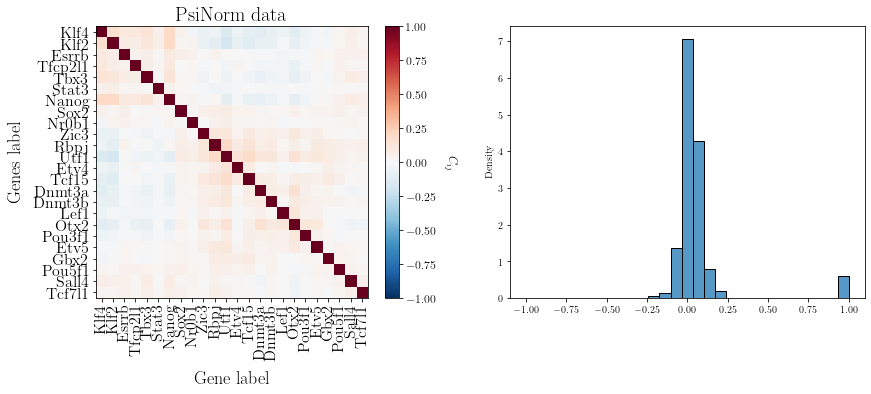

fraction of correctly inffered interactions: 0.39
Wrong Ints:  Stat3 - Dnmt3b val = -0.02
Wrong Ints:  Nanog - Pou3f1 val = -0.03
Wrong Ints:  Stat3 - Gbx2 val = -0.00
Wrong Ints:  Stat3 - Tfcp2l1 val = 0.02
Wrong Ints:  Tcf7l1 - Esrrb val = 0.04
Wrong Ints:  Tcf7l1 - Klf2 val = 0.02
Wrong Ints:  Tcf7l1 - Nanog val = 0.05
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.02
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.02
Wrong Ints:  Rbpj - Nanog val = 0.02
Wrong Ints:  Rbpj - Tbx3 val = 0.01


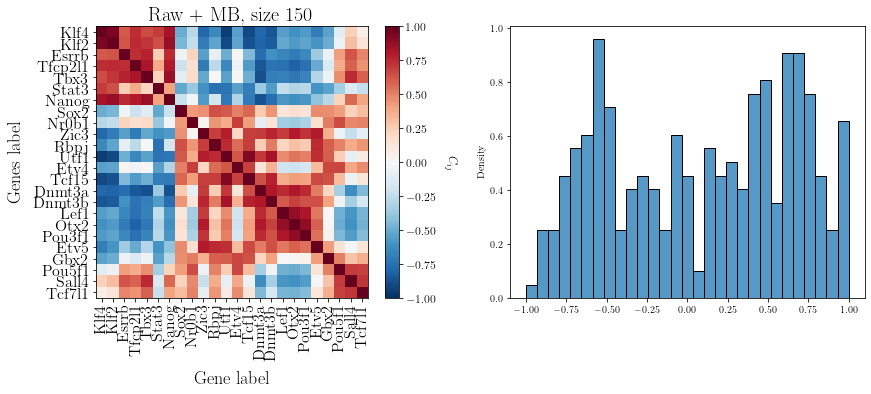

fraction of correctly inffered interactions: 0.61
Wrong Ints:  Stat3 - Gbx2 val = -0.53
Wrong Ints:  Tcf7l1 - Esrrb val = 0.49
Wrong Ints:  Tcf7l1 - Klf2 val = 0.13
Wrong Ints:  Tcf7l1 - Nanog val = 0.39
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.50
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.45
Wrong Ints:  Rbpj - Tbx3 val = 0.01


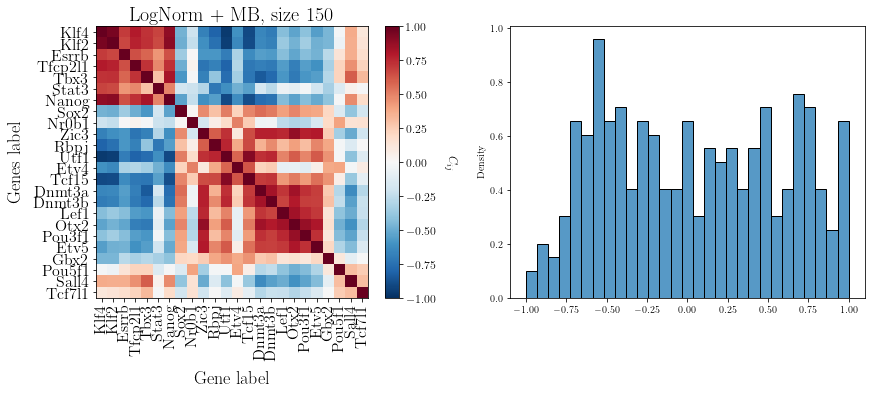

fraction of correctly inffered interactions: 0.67
Wrong Ints:  Stat3 - Gbx2 val = -0.33
Wrong Ints:  Tcf7l1 - Esrrb val = 0.17
Wrong Ints:  Tcf7l1 - Klf2 val = 0.13
Wrong Ints:  Tcf7l1 - Nanog val = 0.18
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.15
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.22


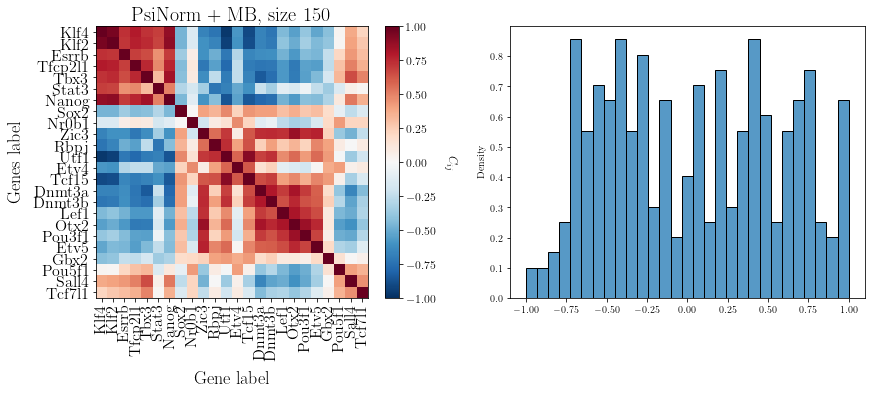

fraction of correctly inffered interactions: 0.67
Wrong Ints:  Stat3 - Gbx2 val = -0.35
Wrong Ints:  Tcf7l1 - Esrrb val = 0.31
Wrong Ints:  Tcf7l1 - Klf2 val = 0.27
Wrong Ints:  Tcf7l1 - Nanog val = 0.36
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.21
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.36


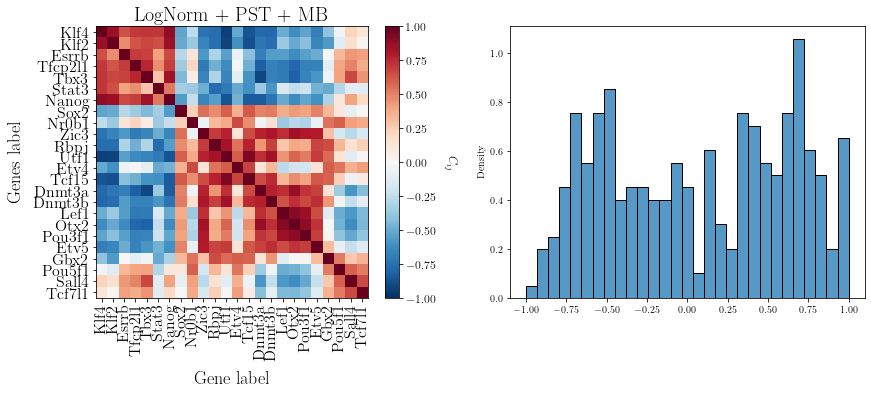

fraction of correctly inffered interactions: 0.67
Wrong Ints:  Stat3 - Gbx2 val = -0.50
Wrong Ints:  Tcf7l1 - Esrrb val = 0.41
Wrong Ints:  Tcf7l1 - Klf2 val = 0.02
Wrong Ints:  Tcf7l1 - Nanog val = 0.20
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.38
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.37


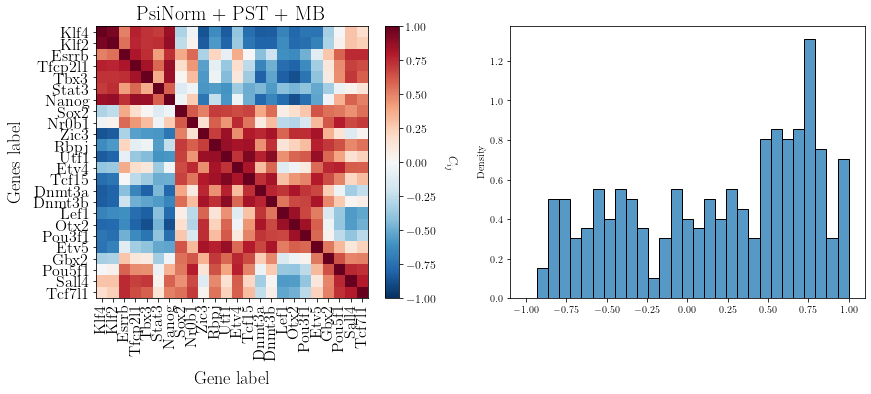

fraction of correctly inffered interactions: 0.67
Wrong Ints:  Stat3 - Gbx2 val = -0.34
Wrong Ints:  Tcf7l1 - Esrrb val = 0.75
Wrong Ints:  Tcf7l1 - Klf2 val = 0.24
Wrong Ints:  Tcf7l1 - Nanog val = 0.50
Wrong Ints:  Tcf7l1 - Nr0b1 val = 0.70
Wrong Ints:  Tcf7l1 - Tfcp2l1 val = 0.65


In [22]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
save_matx = False
# optimize the code of the previous cell
bins = np.linspace(-1, 1, 30)
interaction_thr_Pearson = 0.03

inferred_frac = np.zeros(len(df_list))
info_int = np.zeros((4,18,len(df_list)))
for i in range(len(df_list)):
    cm = np.corrcoef(df_list[i])
    # np.fill_diagonal(cm, float("Nan")) # remove the diagonal
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    figfunc.plotmat(cm, fig, ax[0], df_raw.index, df_name[i], fix=True)
    sns.histplot(np.ndarray.flatten(cm), bins=bins, ax=ax[1], stat="density")
    plt.show()
    
    if save_matx:
        np.save(path_data + "OUT_Pearson/CM_" + df_name[i] + ".npy", cm)
    
    inferred_frac[i], info_int[:,:,i], _ = funcs_general.TP_plot(TPtrial_list, cm, genes_order, 
                                                   inferred_int_thr = interaction_thr_Pearson, Norm_Matx = False,
                                                   data_type=df_name[i],
                                                   figplot=False, verbose=False, nbin=30, Norm = False)
    print(f"fraction of correctly inffered interactions: {inferred_frac[i]:.2f}")
    for j in range(len(TPtrial_list)): 
        if info_int[3,j,i]==0:
            print("Wrong Ints: ", genes_order[info_int[0,j,i].astype(int)], "-", genes_order[info_int[1,j,i].astype(int)], f"val = {info_int[2,j,i]:.2f}")
    

In [23]:
# Evaluate the number of known interaction for all the cm matrices in a for
known_int_frac = np.zeros(len(df_list))
for i in range(len(df_list)):
    cm = np.load(path_data + "OUT_Pearson/CM_" + df_name[i] + ".npy")
    known_int_frac[i] = funcs_general.TP_plot(TPtrial_list, cm, genes_order, data_type=df_name[i], inferred_int_thr = interaction_thr_Pearson, figplot=False, verbose=False, nbin=30, Norm = False)[0]
    # print the number of known interactions
    print(f"Number of known interactions for {df_name[i]}: {known_int_frac[i]:.2f}")

Number of known interactions for Bulk data: 0.56
Number of known interactions for Raw data: 0.39
Number of known interactions for LogNorm data: 0.44
Number of known interactions for PsiNorm data: 0.39
Number of known interactions for Raw + MB, size 150: 0.61
Number of known interactions for LogNorm + MB, size 150: 0.67
Number of known interactions for PsiNorm + MB, size 150: 0.67
Number of known interactions for LogNorm + PST + MB: 0.67
Number of known interactions for PsiNorm + PST + MB: 0.67


# Sanity Checks

Analysing:  Bulk data


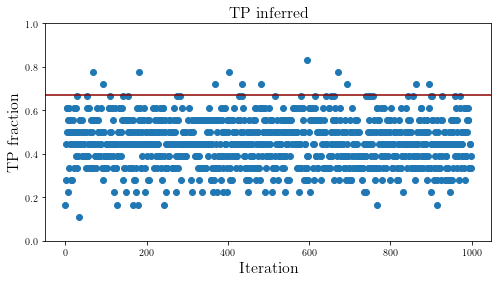

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


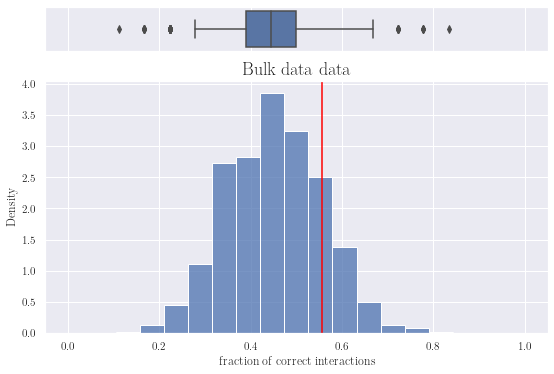

Analysing:  Raw data


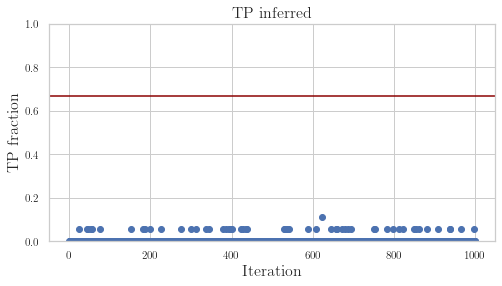

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


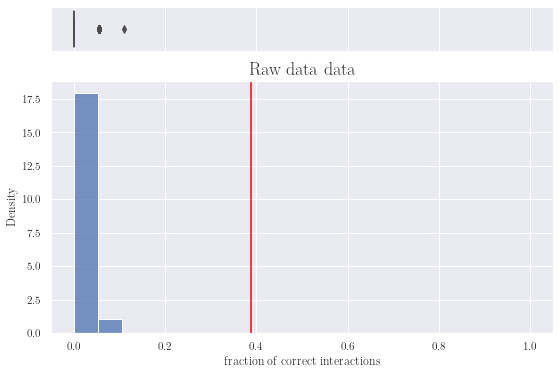

Analysing:  LogNorm data


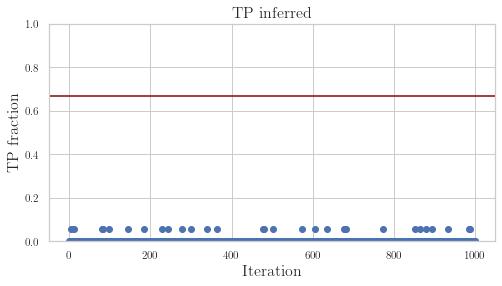

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


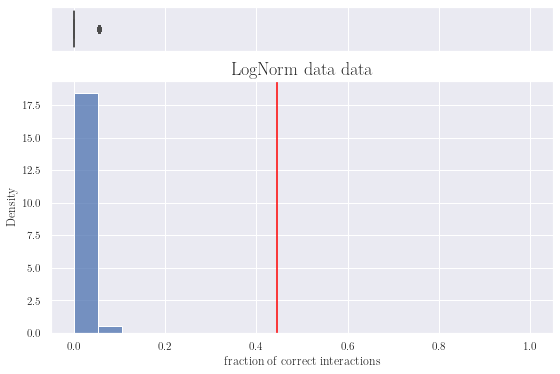

Analysing:  PsiNorm data


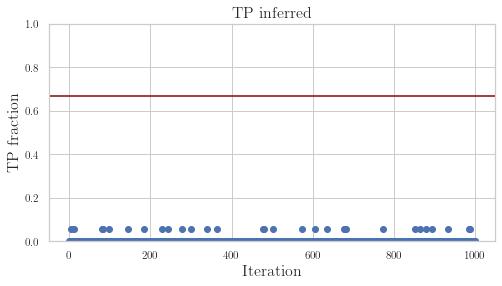

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


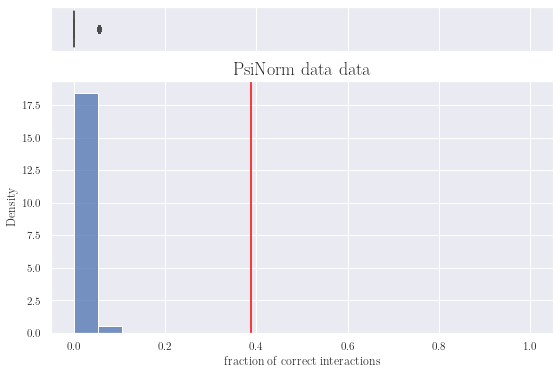

Analysing:  Raw + MB, size 150


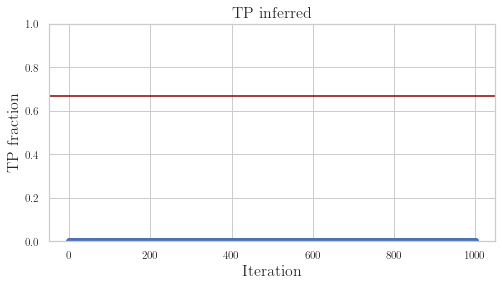

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


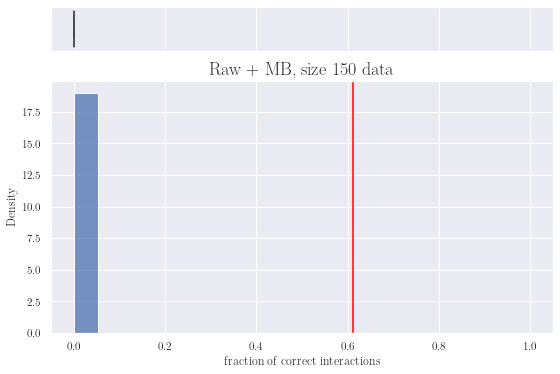

Analysing:  LogNorm + MB, size 150


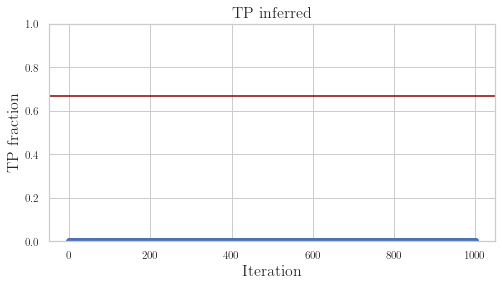

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


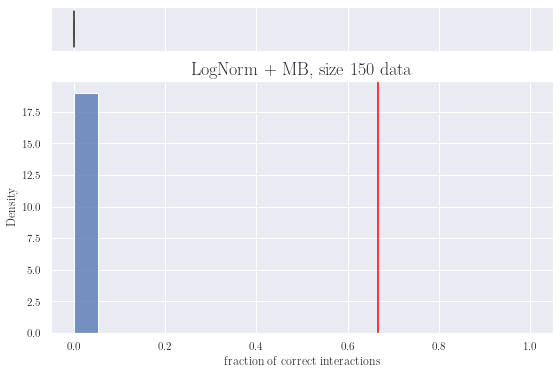

Analysing:  PsiNorm + MB, size 150


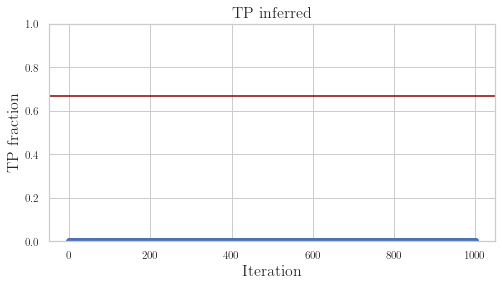

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


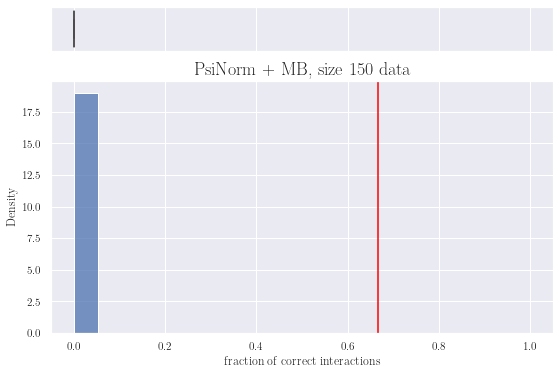

Analysing:  LogNorm + PST + MB


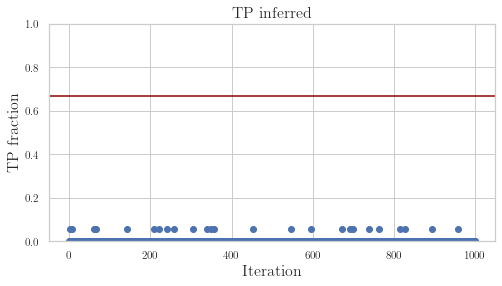

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


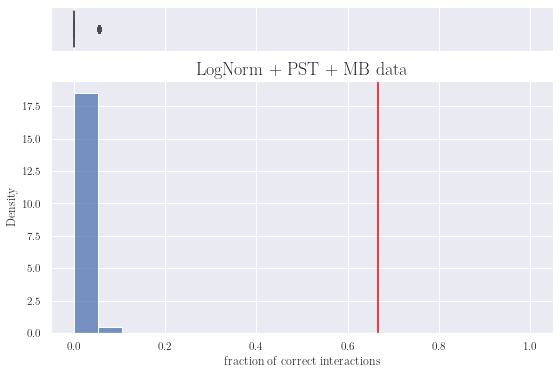

Analysing:  PsiNorm + PST + MB


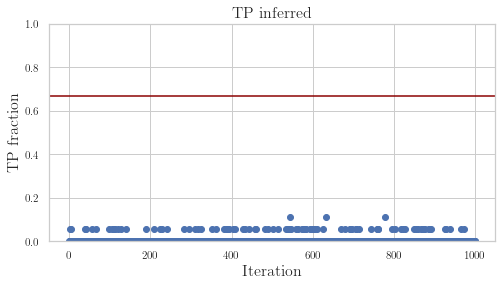

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


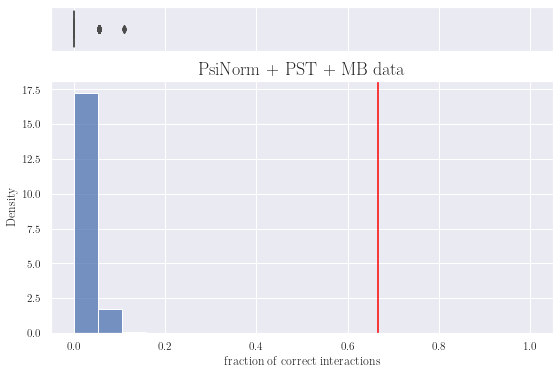

In [24]:
# Evaluate the number of known interaction for all the cm matrices in a for
N_test = 1000
corr_matrices_all = np.zeros((N_test, len(genes_order), len(genes_order), len(df_list)))
for i in range(len(df_list)):
    print("Analysing: ", df_name[i])
    TP_frac_rnd, info_int_rnd, corr_matrices_all[:,:,:,i] = funcs_sanity.shuffle_dataframe(df_list[i], genes_order, TPtrial_list, inferred_int_thr = interaction_thr_Pearson, N_test=N_test)
    funcs_sanity.plot_TP_fraction(TP_frac_rnd, known_int_frac[i], df_name[i])
    # funcs_sanity.fit_normal_distribution(corr_matrices, noise_thr=3, text=df_name[i])

# $H_0 =$ all the known interactions are due to chance

In [25]:
def TP_distribution(interaction_list, interaction_matrices, genes_list):

    int_val = np.zeros((len(interaction_list), interaction_matrices.shape[0]))
    for ii in range(len(interaction_list)):
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1 (target)
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0 (source)
            
        # Get the interaction value and the sign of the interaction
        int_val[ii,:] = interaction_matrices[:,gene1_idx[0], gene0_idx[0]]


    return(int_val)
        

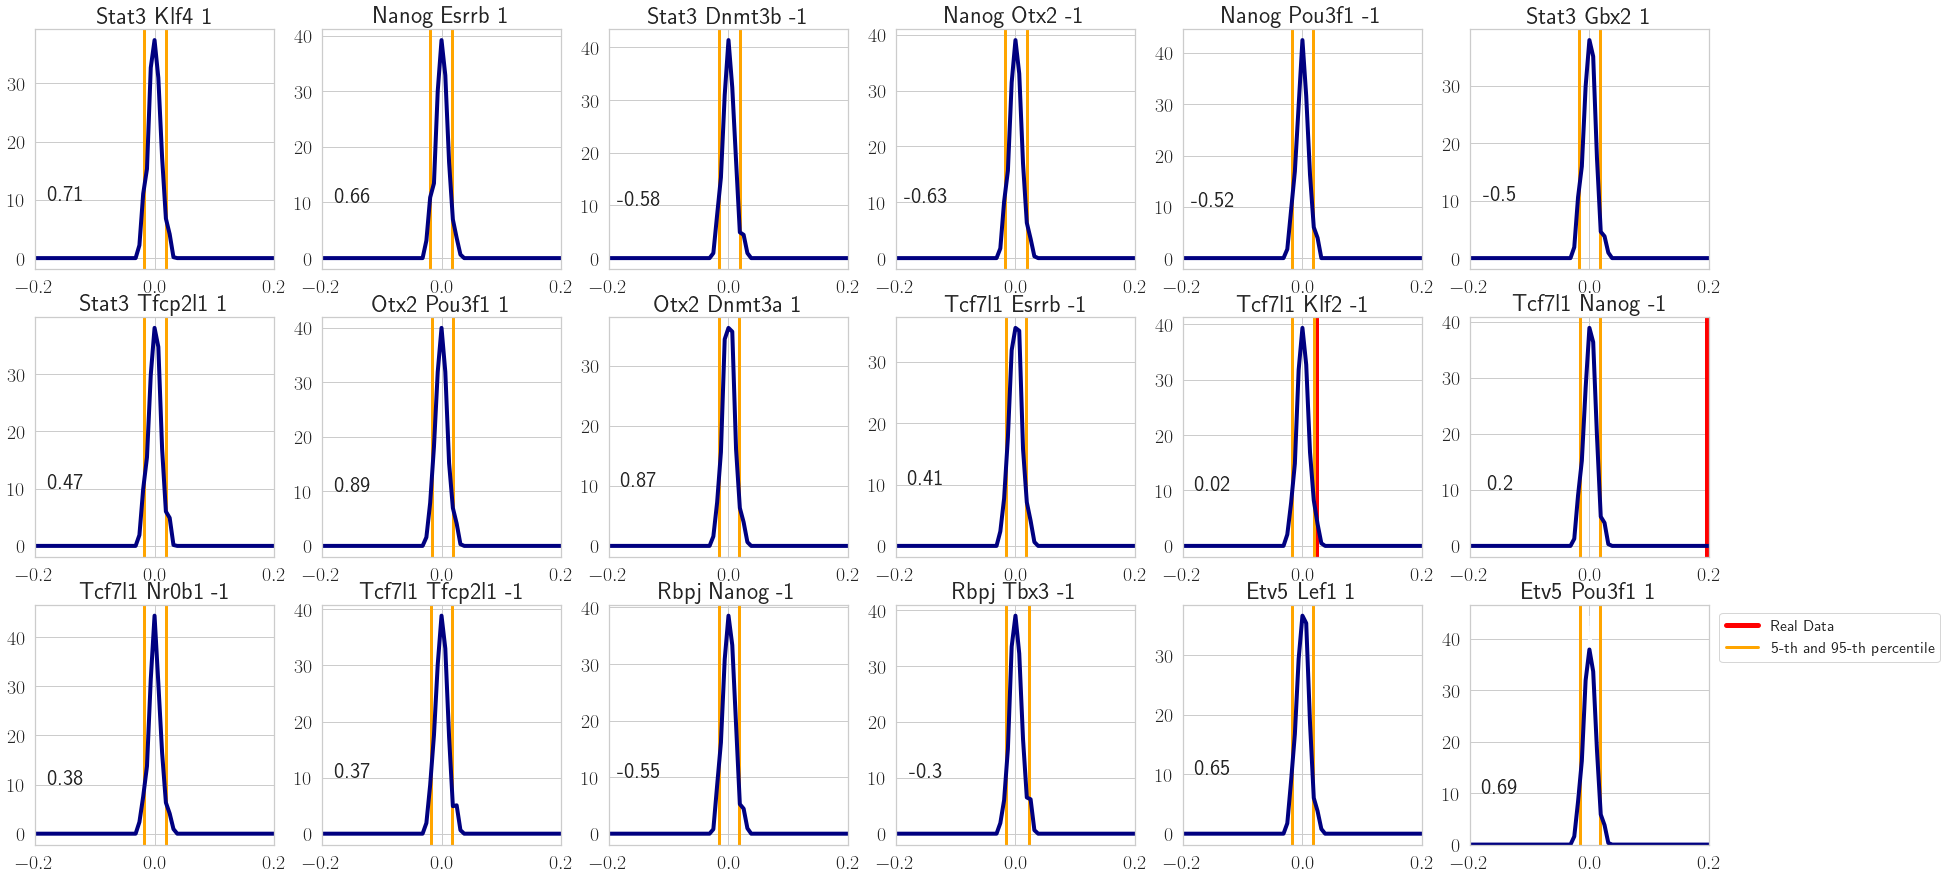

In [27]:
interactions_shuffled = TP_distribution(TPtrial_list, corr_matrices_all[:,:,:,7], genes_order)

# Create a figure with 3 columns and 6 rows
fig, axs = plt.subplots(3, 6, figsize=(30,15))

# Create a list to store the histograms
histograms = []

# Iterate over the rows and columns of the subplot to compute the histograms
for ii in range(info_int.shape[1]):
    # Compute the histogram
    bins_thr = 0.15
    bins = np.linspace(-bins_thr-0.1, bins_thr+0.1, 80)
    nn, bins_J, _ = plt.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='white')
    centroids_J = (bins_J[1:] + bins_J[:-1]) / 2
    
    # Store the histogram in the list
    histograms.append((centroids_J, nn))

# Iterate over the histograms to plot them in the main loop
check = len(TPtrial_list)

for ii, (centroids_J, nn) in enumerate(histograms):
    # Get the axis object for the current subplot
    ax = axs[ii // 6, ii % 6]

    ax.set_xlim([-bins_thr-0.6, bins_thr+0.6])
    quant = np.quantile(interactions_shuffled[ii,:],[0.05, 0.5, 0.95])
    xmin, xmax = ax.get_xlim()
    ax.axvline(x=info_int[2,ii,7], color="red", lw=5, label="Real Data")
    ax.set_title(TPtrial_list[ii], fontsize=24)
    ax.axvline(x=quant[0], color="orange", lw=3, label="5-th and 95-th percentile")
    ax.axvline(x=quant[2], color="orange", lw=3)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.text(-0.15, 10, np.round(info_int[2,ii,7],2), fontsize=22, ha="center",weight='bold')
    ax.set_xlim([-0.2, 0.2])
    
    # Plot the histogram
    ax.plot(centroids_J, nn, color="navy", lw=4)
    
    # 5-th and 95-th percentile
    perc_5 = quant[0]
    perc_95 = quant[2]
    if (info_int[2,ii,7]<=quant[0]) and (info_int[2,ii,7]>=quant[2]):
        print("IN random: ", TPtrial_list[ii], info_int[2,ii,7])
        check -= 1
plt.legend( fontsize=16,bbox_to_anchor=(1.01, 1))
    

# Show the figure
plt.show()
